In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
sns.set(font_scale=2)

import pandas as pd
from sklearn.linear_model import HuberRegressor, LinearRegression, BayesianRidge
from xgboost import XGBRegressor

In [2]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')

%matplotlib inline
linewidth = 2

# Energy resolution on random graph

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
def energy_resolution_metric(y_true, y_pred):
    return np.std((y_true - y_pred) / y_true)
energy_resolution_score = make_scorer(energy_resolution_metric, greater_is_better=False)

In [4]:
def get_data(E_raw, z, E_true, experiment = '.npy'):
    #E_raw, E_true -- .npy files

    E_raw_test = np.load(E_raw + 'test' + experiment)
    E_raw_val = np.load(E_raw + 'test' + experiment)
    
    E_true_test = np.load(E_true + 'test' + experiment)
    E_true_val = np.load(E_true + 'test' + experiment)
    
    z_test = np.load(z + 'test' + experiment)
    z_val = np.load(z + 'test' + experiment)
    
    assert(len(E_raw_test)==len(E_true_test))
    
    X_test, X_val = np.vstack([E_raw_test, z_test]).T, np.vstack([E_raw_val, z_val]).T
    
    return X_test, X_val, E_true_test, E_true_val

In [22]:
def get_data_z(E_raw, z, E_true, experiment = '.npy'):
    #E_raw, E_true -- .npy files

    E_raw_test = np.load(E_raw + 'test' + experiment)
    E_raw_val = np.load(E_raw + 'test' + experiment)
    
    E_true_test = np.load(E_true + 'test' + experiment)
    E_true_val = np.load(E_true + 'test' + experiment)
    
    z_test = np.load(z + 'test' + experiment)
    z_val = np.load(z + 'test' + experiment)
    
    assert(len(E_raw_test)==len(E_true_test))
    
    X_test, X_val = np.vstack([E_raw_test, z_test]).T, np.vstack([E_raw_val, z_val]).T
    
    return X_test, X_val, E_true_test, E_true_val, z_test, z_val

## Using a quantile transformation to evenly slide the window through the energies 

In [6]:
E_true_val = np.load('E_true_rand_test.npy')

In [7]:
E_true_val.shape

(4963,)

In [8]:
E_pred_val = np.load('E_pred_rand_test.npy')

In [9]:
z_val = np.load('z_rand_test.npy')

In [10]:
z_val.shape

(4963,)

In [11]:
len(E_pred_val)==len(E_true_val)==len(z_val)

True

Text(0.5, 1.0, 'z')

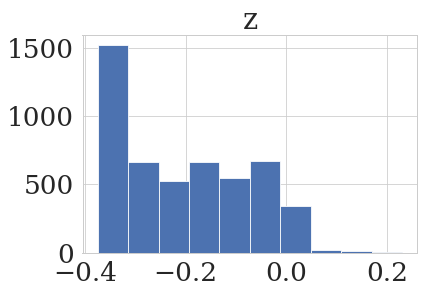

In [12]:
plt.hist(z_val)
plt.title('z')

Text(0.5, 1.0, 'E')

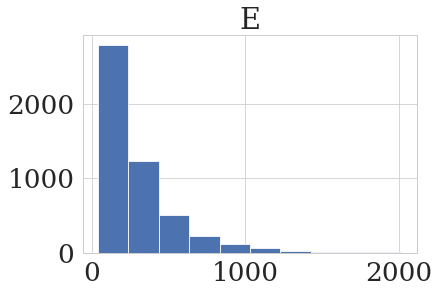

In [13]:
plt.hist(E_pred_val)
plt.title('E')

In [14]:
len(z_val)

4963

In [15]:
len(E_pred_val)

4963

In [16]:
sum(E_pred_val <= 10)

0

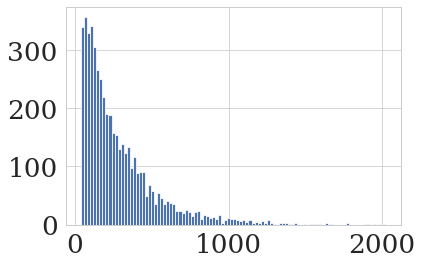

In [17]:
plt.hist(E_pred_val, bins = 100);

Text(0.5, 0, 'True Energy')

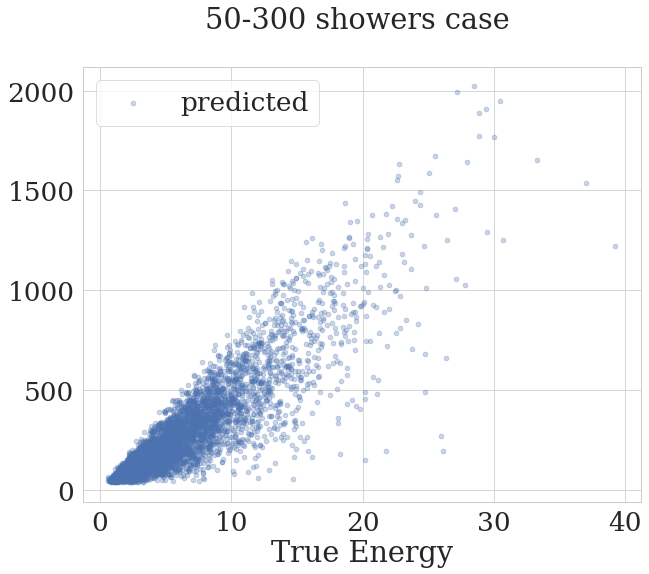

In [18]:
plt.figure(figsize =(10,8))

plt.scatter(E_true_val, E_pred_val, alpha=0.3, label = 'predicted')

plt.legend()
plt.title("50-300 showers case \n")
plt.xlabel('True Energy')

In [6]:
def rolling_window_er(x, y, window=0.1, step=10):
    step = window / step
    start = x.min()
    end = x.max()
    # step back a little from the edges so that there are no edge effects due to low statistics 
    x_lin = np.arange(start + window / 3, end - window / 3, step=step)
    y_lin = []
    for current_center in x_lin:
        # count ER bit by bit with the center at current_center and span = window
        idx = (x < current_center + window / 2) & (x > current_center - window / 2)
        y_lin.append(y[idx].std())
    return x_lin, np.array(y_lin)

In [7]:
def rolling_window_er_z(x, y, window=0.1, step=10):
    step = window / step
    start = min(x)
    end = max(x)

    # step back a little from the edges so that there are no edge effects due to low statistics 
    x_lin = np.arange(start + window / 3, end - window / 3, step=step)
    y_lin = []
    for current_center in x_lin:
        # count ER bit by bit with the center at current_center and span = window
        idx = (x < current_center + window / 2) & (x > current_center - window / 2)
        y_lin.append(y[idx].std())
    return x_lin, np.array(y_lin)

In [9]:
def predict_er_z(X_test, E_test, X, E, z, window=0.1, step=10, q=20, use_box_cox=False, regressor = HuberRegressor()):
    qt = QuantileTransformer(n_quantiles=q, random_state=0)

    lr = regressor
    lr.fit(X_test, E_test)

    E_pred = lr.predict(X)
    idx_sorted = np.argsort(z)
    X = X[idx_sorted]
    E_pred = E_pred[idx_sorted]
    E = E[idx_sorted]
    
    # use box-cox + quantile transformation so that the data lies uniformly in the interval [0, 1] 
    if use_box_cox:
        z_quantile = qt.fit_transform(np.log(-z).reshape(-1, 1)).reshape(-1)
    else:
        z_quantile = qt.fit_transform(z.reshape(-1, 1)).reshape(-1)
    
    E_pred = lr.predict(X)
    x, y = rolling_window_er_z(z_quantile, (E - E_pred) / E, window=window, step=step)
    if use_box_cox:
        x = np.exp(qt.inverse_transform(x.reshape(-1, 1)).reshape(-1))
    else:
        x = qt.inverse_transform(x.reshape(-1, 1)).reshape(-1)
        
        
    return x, y

def generate_bootstrap_data_z(X_test, E_test, X, E, z,  boot=100, window=0.1, step=10, q=20, use_box_cox=False):
    z_true_boot = []
    ER_boot = []
    qt = QuantileTransformer(n_quantiles=q, random_state=0)

    for i in range(boot):
        boot_idx = np.random.randint(low=0, high=len(z), size=len(z))
        X_boot = X[boot_idx]
        E_boot = E[boot_idx]
        z_boot = z[boot_idx]
        x, y = predict_er_z(X_test, E_test, X_boot, E_boot, z_boot, window=window, step=step, q=q, use_box_cox=use_box_cox)
        z_true_boot.append(x)
        ER_boot.append(y)

    z_true_boot = np.array(z_true_boot)
    ER_boot = np.array(ER_boot)
    return z_true_boot, ER_boot


## Checking Bayes Variance to Choose the Optimal Window Size 

In [10]:
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

## Enargy Resolution for different graphs configurations 

In [11]:
E_RAW = ['E_pred_rand_', 'E_pred_200_',
         'E_pred_50_','E_pred_1_']

In [12]:
Z_coordinates = ['z_rand_', 'z_200_',
         'z_50_', 'z_1_']

In [13]:
E_TRUE = ['E_true_rand_', 'E_true_200_',
          'E_true_50_', 'E_true_1_']

In [14]:
NAME = ['50-300 showers per brick',  '200 showers per brick', '50 showers per brick', '1 shower per brick']

-----

In [18]:
def fill_na(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[0]), 0)
    np.maximum.accumulate(idx, axis=0, out=idx)
    out = arr[idx]
    return out

In [28]:
def plot_ER_z(E_RAW, E_TRUE, NAME, colors, colors_,  use_box_cox=False, experiment = '.npy'):
    
    plt.figure(figsize=(12, 8), dpi=100)
        
    window = 0.07
    
    i = 0
    
    X_test, X_val, E_true_test, E_true_val, z_test, z_val = get_data_z(E_RAW[i], Z_coordinates[i], 
                                                          E_TRUE[i], experiment)
        
        
    z_full, ER_full = predict_er_z(X_test, E_true_test, X_val, E_true_val, z_val,
                                          window=window, q=5, use_box_cox=use_box_cox)
    z_boot, ER_boot = generate_bootstrap_data_z(X_test, E_true_test, X_val, E_true_val, z_val, boot=100, 
                                                    window=window, q=5, use_box_cox=use_box_cox)

    lower, upper = np.percentile(ER_boot, [2.5, 97.5], axis=0)
    z_mean = z_boot.mean(axis=0)
    ER_mean = ER_boot.mean(axis=0)
    idx = 30
    print(idx)
    lower = lower[idx:]
    upper = upper[idx:]
    z_mean = z_mean[idx:]
    ER_mean = ER_mean[idx:]
    print(z_boot.shape)
    ER_boot = ER_boot[:, idx:]
    z_boot = z_boot[:, idx:]
    ER_full = ER_full[idx:]
    z_full = z_full[idx:]
    
    plt.fill_between(z_mean, upper, lower, color = 'lightcoral', alpha=0.4,  linewidth=2);
    plt.plot(z_boot.T, ER_boot.T, c='lightcoral', alpha=0.02);
    plt.plot(z_mean, ER_mean, c='firebrick', alpha=0.6, linewidth=2)

    plt.xlabel("Z coordinate")
    plt.ylabel("Mean ER")
    
    leg = plt.legend()


    plt.savefig("ER_comparison_z_all.pdf", bbox_inches='tight')
    plt.show()
    
    return lower, upper, z_mean, ER_mean

0


No handles with labels found to put in legend.


30
(100, 137)


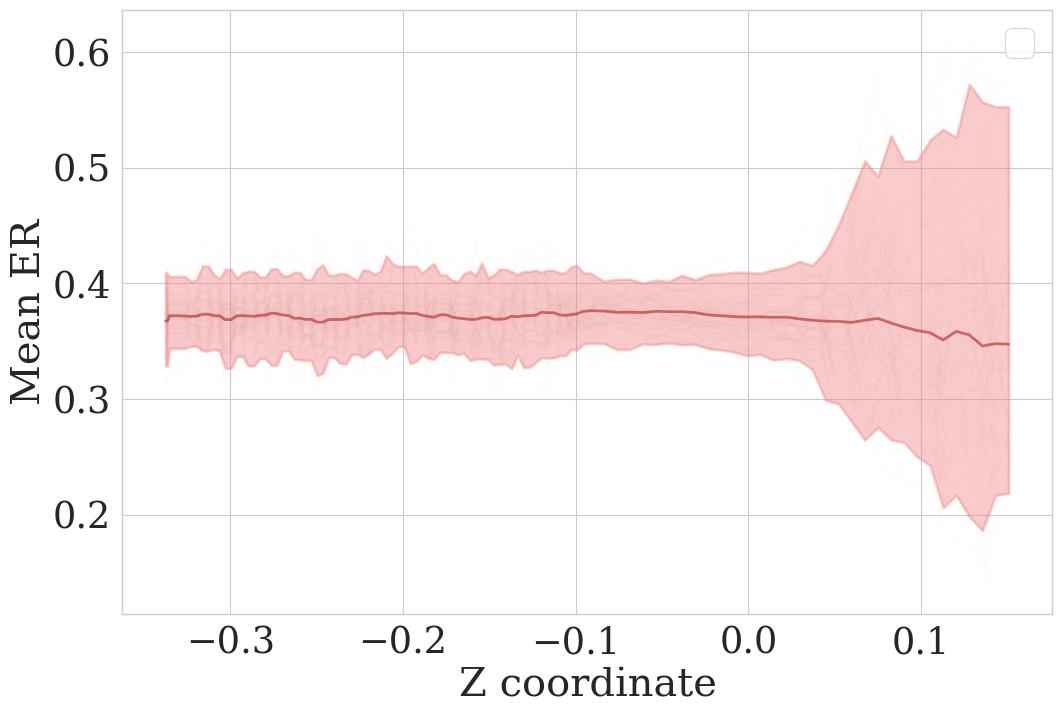

In [29]:
lower, upper, z_mean, ER_mean = plot_ER_z(E_RAW, E_TRUE, NAME, colors, colors_, use_box_cox=False, experiment = '_2.npy')